In [1]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import math
import keras.backend as K
import csv
from tqdm import tqdm
from keras.models import Model
import copy

2021-12-24 14:37:41.110330: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-24 14:37:41.110356: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### Use this part with colab 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip ./drive/MyDrive/CMPLabData/ImageDataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: ImageDataset/TrainSet/nonword/0_ghloughts.png  
  inflating: ImageDataset/TrainSet/nonword/100022_toagged.png  
  inflating: ImageDataset/TrainSet/nonword/100033_buinnth.png  
  inflating: ImageDataset/TrainSet/nonword/100061_splaist.png  
  inflating: ImageDataset/TrainSet/nonword/100066_thrancs.png  
  inflating: ImageDataset/TrainSet/nonword/10007_grymms.png  
  inflating: ImageDataset/TrainSet/nonword/100085_barlt.png  
  inflating: ImageDataset/TrainSet/nonword/100097_stroughnth.png  
  inflating: ImageDataset/TrainSet/nonword/10010_whoann.png  
  inflating: ImageDataset/TrainSet/nonword/100133_ghleett.png  
  inflating: ImageDataset/TrainSet/nonword/100136_sckumpce.png  
  inflating: ImageDataset/TrainSet/nonword/100139_varnt.png  
  inflating: ImageDataset/TrainSet/nonword/100145_stant.png  
  inflating: ImageDataset/TrainSet/nonword/100161_thwoarped.png  
  inflating: ImageDataset/TrainSet/nonword/100169_guarphths.

### Import Data and Models

In [4]:
import pickle
infile = open("check_points/CNN_model",'rb')
model = pickle.load(infile)
infile.close()

In [4]:
nonwords = []
words = []


with open("train_dataset_unique_words.csv", 'r') as file:
    reader = csv.reader(file)
    for row in reader:
        if row[1] == '1':
            words.append(row[0])
        else:
            nonwords.append(row[0])


In [ ]:


nonword_img = []
word_img = []
entries = os.listdir('ImageDataset/TrainSet/nonword/')
seen = []
for e in entries:
    w = e.split('_')[1].split('.')[0]
    if w in nonwords and w not in seen:
        seen.append(w)
        s = e.split('.')[0] + '.png'
        nonword_img.append(s)



entries = os.listdir('ImageDataset/TrainSet/word/')
seen = []
for e in entries:
    w = e.split('_')[1].split('.')[0]
    if w in words and w not in seen:
        seen.append(w)
        s = e.split('.')[0] + '.png'
        word_img.append(s)



In [ ]:
print(len(word_img))
print(len(words))

print(len(nonword_img))
print(len(nonwords))

4690
4690
4570
4570


In [5]:
model.pop()
model.compile()
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 148, 32)       896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 36, 64)        0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 6, 36, 64)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 34, 128)        7

In [ ]:
prob = []
all_test_set = words+nonwords
all_feature_vec = []
for e in tqdm(nonword_img):
    filename = "ImageDataset/TrainSet/nonword/" + e 
    img = image.load_img(filename,target_size=(30,150))
 
    Y = image.img_to_array(img)
    X = np.expand_dims(Y,axis=0)
    X = X/255
    val = model.predict(X)
    all_feature_vec.append(val.reshape(256))

for e in tqdm(word_img):
    filename = "ImageDataset/TrainSet/word/" + e 
    img = image.load_img(filename,target_size=(30,150))
 
    Y = image.img_to_array(img)
    X = np.expand_dims(Y,axis=0)
    X = X/255
    val = model.predict(X)
    all_feature_vec.append(val.reshape(256))


100%|██████████| 4690/4690 [04:03<00:00, 19.30it/s]


In [ ]:
import pickle
outfile = open("check_points/all_feature_vec",'wb')
pickle.dump(all_feature_vec,outfile)
outfile.close()

In [5]:
import pickle
infile = open("check_points/all_feature_vec",'rb')
all_feature_vec = pickle.load(infile)
infile.close()

### NN Stan

In [6]:

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


In [7]:
stan_model = """
functions {
  vector[] nn_predict(matrix x, vector d_t_h1, vector d_t_h2,vector y_bias) {
    int N = rows(x);
    int num_labels = cols(y_bias) + 1;
    vector[num_labels] output_layer_logit[N];
    vector[N] ones = rep_vector(1., N);
    real b1 = y_bias[1];
    real b2 = y_bias[2];
    output_layer_logit[1:N, 1] = to_array_1d(x * d_t_h1 + b1);
    output_layer_logit[1:N, 2] = to_array_1d(x * d_t_h2 + b2);
    
    return(output_layer_logit);
  }
}

data {
  int N; // Number of training samples
  int P; // Number of predictors (features)
  matrix[N, P] x; // Feature data
  int labels[N]; // Outcome labels

}

transformed data {
  int num_labels = 2; // How many labels are there
}

parameters {

  vector[P] data_to_hidden_weights1; // Data -> Hidden 1
  vector[P] data_to_hidden_weights2; // Data -> Hidden 1
  vector[num_labels] y_bias; // Bias. 
}

transformed parameters {
  vector[num_labels] output_layer_logit[N]; // Predicted output layer logits

  output_layer_logit = nn_predict(x,
                                  data_to_hidden_weights1,
                                  data_to_hidden_weights2,
                                  y_bias);

}

model {
  // Priors
  to_vector(data_to_hidden_weights1) ~ std_normal();
  to_vector(data_to_hidden_weights2) ~ std_normal();

  y_bias ~ std_normal();
    
  for(n in 1:N) { // Likelihood
    labels[n] ~ categorical_logit(output_layer_logit[n]);
  }
}

"""

In [12]:
# Put our data in a dictionary
data = {
          'N' :  len(all_feature_vec) ,# Number of training samples
          'P': len(all_feature_vec[0]),# Number of predictors (features)
          'x' : all_feature_vec, # Feature data
          'labels' : correct_option  # Outcome nonword=1

        }


### Old Stan

In [13]:
import nest_asyncio
nest_asyncio.apply()
import pystan

In [14]:
%%time
# Compile the model
sm = pystan.StanModel(model_code=stan_model, extra_compile_args=["-w"])


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_269c02f2d86bb054be84b8156eff8099 NOW.


CPU times: user 1.93 s, sys: 177 ms, total: 2.11 s
Wall time: 1min 16s


In [15]:

# Train the model and generate samples
fit = sm.sampling(data=data, iter=1000, chains=4, seed=1)


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


**Save fit object**

In [24]:
import pickle
outfile = open("./drive/MyDrive/CMPLabData/stan_fit",'wb')
pickle.dump(fit,outfile)
outfile.close()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  This is separate from the ipykernel package so we can avoid doing imports until


In [25]:
outfile = open("./drive/MyDrive/CMPLabData/stan_model",'wb')
pickle.dump(sm,outfile)
outfile.close()

**check hmc diagnostics**

In [16]:
pystan.check_hmc_diagnostics(fit)

{'Rhat': True,
 'divergence': True,
 'energy': True,
 'n_eff': True,
 'treedepth': True}

In [17]:
summary_dict = fit.summary()
df = pd.DataFrame(summary_dict['summary'], 
                  columns=summary_dict['summary_colnames'], 
                  index=summary_dict['summary_rownames'])
print(df)


                                  mean   se_mean  ...        n_eff      Rhat
data_to_hidden_weights1[1]   -0.465301  0.013821  ...  4767.497211  0.998347
data_to_hidden_weights1[2]   -0.000120  0.014211  ...  4977.220703  0.998760
data_to_hidden_weights1[3]   -0.482744  0.013385  ...  2838.652265  0.998827
data_to_hidden_weights1[4]   -0.780688  0.012202  ...  3421.092511  0.999120
data_to_hidden_weights1[5]    0.393671  0.013064  ...  3682.078872  0.998703
...                                ...       ...  ...          ...       ...
output_layer_logit[9257,2]    6.148464  0.064884  ...  3521.778683  0.999196
output_layer_logit[9258,2]    5.015247  0.048386  ...  3187.503656  0.999608
output_layer_logit[9259,2]   10.271046  0.076484  ...  3778.412067  0.999058
output_layer_logit[9260,2]    3.637602  0.047725  ...  3438.487983  0.999595
lp__                       -837.799684  0.687333  ...   517.585356  1.006112

[19035 rows x 10 columns]


In [18]:
for f in df["Rhat"]:
    if f > 1.01:
        print(f)

**Save Summary DataFrame**

In [19]:
# df.to_csv(r'./NNStanResults.txt', header=None, index=None, sep=' ', mode='a')
df.to_pickle("./drive/MyDrive/CMPLabData/summary.pkl")

**Plot the fit**

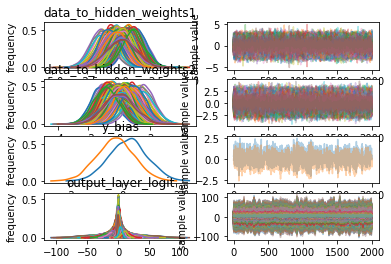

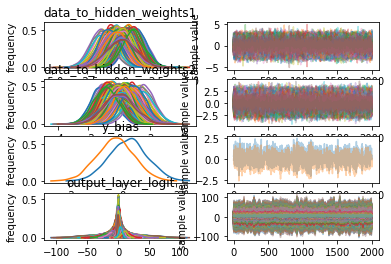

In [20]:
fit.plot()

In [ ]:
# print(fit)

**Extract weights and layers from stan model**

In [21]:
data_to_hidden_weights1 = fit["data_to_hidden_weights1"]
data_to_hidden_weights2 = fit["data_to_hidden_weights2"]
ouput_layer_logit = fit["output_layer_logit"]
y_bias = fit["y_bias"]

In [22]:
print(data_to_hidden_weights1)
print(data_to_hidden_weights2)
print(ouput_layer_logit)
print(y_bias)

[[-0.85110998  1.78665504 -0.74829373 ...  2.73131707 -1.19236961
   0.29083899]
 [ 1.24342461 -0.44018791 -0.61211774 ...  0.36886833 -0.93600116
   0.66793556]
 [ 0.42394776 -0.38800501 -0.66929256 ...  0.33119028  1.40642466
   0.99215108]
 ...
 [-1.08730782 -0.01252183 -0.19534351 ...  1.40254063 -1.64959796
   0.43441658]
 [-0.35358376 -0.88631224 -0.76313459 ...  0.44116074 -0.54159561
   1.30532314]
 [-0.76375621  0.81116827 -0.57689135 ... -0.07219858  0.42156125
  -1.92189599]]
[[-0.04070216 -0.17788182  0.1993279  ... -0.04653229  0.51623022
  -0.3506426 ]
 [-0.37050546  0.52127755  0.47601156 ...  0.5219879  -0.63664372
   0.29451904]
 [ 0.16454779 -0.88193572  0.50410405 ... -0.50023176 -1.8155816
   0.01852976]
 ...
 [ 0.93443018 -1.2708968   0.99340609 ...  0.60248941 -0.86380841
   1.3571097 ]
 [ 1.00827239 -0.760195    0.08151283 ...  1.2767736  -0.76475606
  -0.12777317]
 [ 1.84336689 -1.84727037  0.53825763 ...  1.4239819  -2.52858743
   0.85951095]]
[[[ 16.3122581   

In [23]:
import pickle
outfile = open("./drive/MyDrive/CMPLabData/nn_stan.pkl",'wb')
pickle.dump([data_to_hidden_weights1, data_to_hidden_weights2, ouput_layer_logit, y_bias],outfile)
outfile.close()

## Load Stan Data


In [ ]:
import pickle
infile = open("./drive/MyDrive/CMPLabData/nn_stan.pkl",'rb')
[data_to_hidden_weights1, data_to_hidden_weights2, ouput_layer_logit, y_bias]= pickle.load(infile)
infile.close()

In [ ]:
print(ouput_layer_logit)

[[[  2.27886986  -5.20239222]
  [  3.11617376  -4.73870783]
  [ -4.84049763  -6.56533191]
  ...
  [ -7.95134546   2.07546131]
  [-13.02011629   2.85851907]
  [ -2.12145428  -2.56478061]]

 [[  5.03353609  -1.94809668]
  [  4.69640365  -1.72401141]
  [  4.45301259   1.44580019]
  ...
  [ -2.79761137   4.38624426]
  [ -6.6744833    4.85982424]
  [ -1.33946021  -2.06423561]]

 [[  5.37659801  -1.05611482]
  [  6.71014002  -0.90537619]
  [  3.86428324   0.62041412]
  ...
  [  1.09138647   9.53138747]
  [ -6.14670534   9.00008824]
  [  3.06149303   2.24096599]]

 ...

 [[  2.37272727  -4.11327008]
  [  4.81620316  -3.02062555]
  [  1.7323997   -0.97705489]
  ...
  [ -3.72061155   3.07991096]
  [ -7.1789483    4.38116222]
  [  3.06767483   1.74844402]]

 [[  5.73296696  -0.86561484]
  [  3.64315859  -2.4308695 ]
  [  0.24060262  -0.7708004 ]
  ...
  [ -7.51546414   0.65841939]
  [-12.64627319  -0.0532583 ]
  [ -0.54582829  -1.92011153]]

 [[  4.5692266   -1.83214165]
  [  6.685888    -0.2328

In [ ]:
import pandas as pd

summary_df = pd.read_pickle("./drive/MyDrive/CMPLabData/summary.pkl")

In [ ]:
print(summary_df)

                                    mean   se_mean  ...        n_eff      Rhat
data_to_hidden_weights1[1]     -0.454102  0.017614  ...  2071.219939  0.999742
data_to_hidden_weights1[2]     -0.990991  0.017575  ...  2093.017994  0.999950
data_to_hidden_weights1[3]      0.653190  0.018168  ...  1917.641009  0.998992
data_to_hidden_weights1[4]     -0.017318  0.018793  ...  2939.117255  0.999217
data_to_hidden_weights1[5]     -0.001022  0.016530  ...  3726.834543  0.998925
...                                  ...       ...  ...          ...       ...
output_layer_logit[11665,2]     6.069537  0.097581  ...  1607.640417  1.004557
output_layer_logit[11666,2]     4.465816  0.087856  ...  1717.879281  1.000879
output_layer_logit[11667,2]     6.842789  0.106285  ...  1716.447760  0.999668
output_layer_logit[11668,2]    -0.408653  0.042113  ...  1358.061183  1.002111
lp__                        -1079.720604  0.510289  ...   973.716617  1.001426

[23851 rows x 10 columns]


## Read ACC and RT Data


In [8]:
data = []
acc = []
rt = []
correct_option = []
drift = []
w_prob = []
nonw_prob = []
vocab = []
with open("train_dataset_rt_acc.csv", 'r') as file:
    reader = csv.reader(file)
    for row in reader:
        if row[0] in vocab:
            continue
        vocab.append(row[0])
        data.append(row)
        acc.append(row[5]) # acc ouput of DDM model
        rt.append(float(row[2]))
        drift.append(row[6])
        w_prob.append(row[4])
        nonw_prob.append(row[3])
        if row[1] == "nonword":
            correct_option.append(1)
        else:
            correct_option.append(2)

        

In [10]:
print(data[:5])
print(len(data))
print(len(all_feature_vec))

[['gweles', 'nonword', '1.977', '0.975584', '0.024416', '0.0', '-3.687398377512456'], ['ghroiled', 'nonword', '1.111', '0.999934', '6.6e-05', '0.0', '-9.484721216109884'], ['kwietes', 'nonword', '6.7139999999999995', '0.762476', '0.237524', '0.0', '-1.1662733765339508'], ['sckeighs', 'nonword', '1.947', '0.995293', '0.004707', '0.0', '-5.351874209111934'], ['gooped', 'nonword', '1.728', '0.99395', '0.00605', '0.0', '-5.09998716431695']]
9260
9260


In [11]:
print(len(correct_option))
print(correct_option[:10])
print(nonwords[:10])

9260
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
['gweles', 'ghroiled', 'kwietes', 'sckeighs', 'gooped', 'blerved', 'dwawzed', 'luked', 'smeaotorm', 'sheede']


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


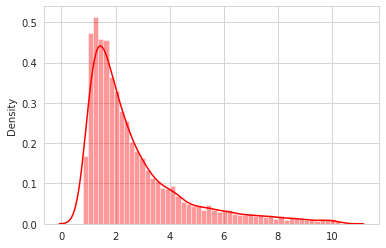

In [ ]:
import seaborn as sns
sns.set_style('whitegrid')
sns.distplot(rt, kde = True, color ='red')

In [ ]:
sns.jointplot(x =w_prob, y =nonw_prob )


Error in callback <function flush_figures at 0x7f9e96c1d0e0> (for post_execute):


KeyboardInterrupt: ignored

## Estimate Parameters

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import nest_asyncio
nest_asyncio.apply()
import pystan

In [ ]:
model = """
functions {
		vector[] nn_predict(matrix x, vector d_t_h1, vector d_t_h2,vector y_bias) {
			int N = rows(x);
			int num_labels = cols(y_bias) + 1;
			vector[num_labels] output_layer_logit[N];
			vector[N] ones = rep_vector(1., N);
			real b1 = y_bias[1];
			real b2 = y_bias[2];
			output_layer_logit[1:N, 1] = to_array_1d(x * d_t_h1 + b1);
			output_layer_logit[1:N, 2] = to_array_1d(x * d_t_h2 + b2);
			
			return(output_layer_logit);
		}
}

data {
		int N; // Number of training samples
		int P; // Number of predictors (features)
		matrix[N, P] x; // Feature data
		int labels[N]; // Outcome labels
		int K;									// number of options
		real rt[N];							// rt
		//real starting_point;			// starting point diffusion model not to estimate
		vector[2] drift_scaling_priors;					// mean and sd of the prior
		vector[2] threshold_priors;						// mean and sd of the prior
		vector[2] ndt_priors;							// mean and sd of the prior
}

parameters {

		vector[P] alpha_data_to_hidden_weights1; // Data -> Hidden 1
		vector[P] alpha_data_to_hidden_weights2; // Data -> Hidden 1
		vector[K] alpha_y_bias; // Bias. 

		real drift_scaling;
		real threshold;
		real ndt;
}
transformed parameters {
		real drift[N];								// trial-by-trial drift rate for predictions
		real threshold_t[N];					// trial-by-trial threshold
		real ndt_t[N];							// trial-by-trial ndt

		vector[K] Q_output_layer_logit[N];						// Q state values

		real transf_drift_scaling;
		real transf_threshold;
		real transf_ndt;
		
		Q_output_layer_logit = nn_predict(x,
																		alpha_data_to_hidden_weights1,
																		alpha_data_to_hidden_weights2,
																		alpha_y_bias);

		transf_drift_scaling = log(1 + exp(drift_scaling));
		transf_threshold = log(1 + exp(threshold));
		transf_ndt = log(1 + exp(ndt));
		for (n in 1:N) {
			drift[n] = transf_drift_scaling * log(inv_logit(Q_output_layer_logit[n][2])/inv_logit(Q_output_layer_logit[n][1]));
			threshold_t[n] = transf_threshold;
			ndt_t[n] = transf_ndt;
			
			}
 }
model {
		to_vector(alpha_data_to_hidden_weights1) ~ std_normal();
		to_vector(alpha_data_to_hidden_weights2) ~ std_normal();

		alpha_y_bias ~ std_normal();
		drift_scaling ~ normal(drift_scaling_priors[1], drift_scaling_priors[2]);
		threshold ~ normal(threshold_priors[1], threshold_priors[2]);
		ndt ~ normal(ndt_priors[1], ndt_priors[2]);

		rt ~ wiener(threshold_t, ndt_t, transf_threshold/2, drift);

		for(n in 1:N) { // Likelihood
			labels[n] ~ categorical_logit(Q_output_layer_logit[n]);
		}

}



"""

In [ ]:
# Put our data in a dictionary
data = {
          'N' :  len(all_feature_vec) ,# Number of training samples
          'P': len(all_feature_vec[0]),# Number of predictors (features)
          'x' : all_feature_vec, # Feature data
          'labels' : correct_option,  # Outcome
          'K': 2,									# number of options
          'rt': rt,
          # 'starting_point': .5,
        	'drift_scaling_priors' : [0, 1],					#mean and sd of the prior
          'threshold_priors' : [5, 1],						# mean and sd of the prior
          'ndt_priors':[0, 1] 	
        
}

### PyStan2

In [ ]:
sm = pystan.StanModel(model_code=model, extra_compile_args=["-w"], verbose=True)


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8fcd4d90560c689bbf239bbfc1b02c3e NOW.
INFO:pystan:OS: linux, Python: 3.7.12 (default, Sep 10 2021, 00:21:48) 
[GCC 7.5.0], Cython 0.29.24


Compiling /tmp/pystan_3qv1tyhd/stanfit4anon_model_8fcd4d90560c689bbf239bbfc1b02c3e_3481108633247581090.pyx because it changed.
[1/1] Cythonizing /tmp/pystan_3qv1tyhd/stanfit4anon_model_8fcd4d90560c689bbf239bbfc1b02c3e_3481108633247581090.pyx
building 'stanfit4anon_model_8fcd4d90560c689bbf239bbfc1b02c3e_3481108633247581090' extension
creating /tmp/pystan_3qv1tyhd/tmp
creating /tmp/pystan_3qv1tyhd/tmp/pystan_3qv1tyhd
x86_64-linux-gnu-gcc -pthread -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fdebug-prefix-map=/build/python3.7-Y7dWVB/python3.7-3.7.12=. -fstack-protector-strong -Wformat -Werror=format-security -g -fdebug-prefix-map=/build/python3.7-Y7dWVB/python3.7-3.7.12=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -DBOOST_RESULT_OF_USE_TR1 -DBOOST_NO_DECLTYPE -DBOOST_DISABLE_ASSERTS -I/tmp/pystan_3qv1tyhd -I/usr/local/lib/python3.7/dist-packages/pystan -I/usr/local/lib/python3.7/dist-packages/pystan/stan/src -I/us

In [ ]:
# Train the model and generate samples
fit = sm.sampling(data=data, iter=1000, chains=4, seed=1, verbose=True)


KeyboardInterrupt: ignored

In [ ]:
pystan.check_hmc_diagnostics(fit)

In [ ]:
summary_dict = fit.summary()
df = pd.DataFrame(summary_dict['summary'], 
                  columns=summary_dict['summary_colnames'], 
                  index=summary_dict['summary_rownames'])
print(df)


In [ ]:
for f in df["Rhat"]:
    if f > 1.01:
        print(f)

### PyStan3

In [ ]:
import nest_asyncio
nest_asyncio.apply()
del nest_asyncio
import stan_jupyter as stan

ModuleNotFoundError: ignored

In [ ]:
posterior = stan.build(stan_model, data=data, random_seed=1)


In [ ]:
fit = posterior.sample(num_chains=4, num_samples=100)


In [ ]:
print()

In [ ]:
model = """
data {
	int<lower=1> N;									// number of data items
	int<lower=1> K;									// number of options
	int<lower=1> trial_block[N];					// trial within block
	vector[N] f_cor;								// feedback correct option
	vector[N] f_inc;								// feedback incorrect option
	int<lower=1, upper=K> cor_option[N];			// correct option
	int<lower=1, upper=K> inc_option[N];			// incorrect option
	int<lower=1> block_label[N];					// block label

	int<lower=-1,upper=1> accuracy[N];				// accuracy (-1, 1)
	real<lower=0> rt[N];							// rt

	real initial_value;								// intial value for learning in the first block

	vector[2] alpha_priors;							// mean and sd of the prior
	vector[2] drift_scaling_priors;					// mean and sd of the prior
	vector[2] threshold_priors;						// mean and sd of the prior
	vector[2] ndt_priors;							// mean and sd of the prior
	real<lower=0, upper=1> starting_point;			// starting point diffusion model not to estimate
}
transformed data {
	vector[K] Q0;
	Q0 = rep_vector(initial_value, K);
}
parameters {
	real alpha;
	real drift_scaling;
	real threshold;
	real ndt;
}
transformed parameters {
	real drift_ll[N];								// trial-by-trial drift rate for likelihood (incorporates accuracy)
	real drift_t[N];								// trial-by-trial drift rate for predictions
	real<lower=0> threshold_t[N];					// trial-by-trial threshold
	real<lower=0> ndt_t[N];							// trial-by-trial ndt

	vector[K] Q;									// Q state values

	real Q_mean;									// mean across all options
	real Q_mean_pres[N];							// mean Q presented options
	real delta_Q[N];								// Qcor - Qinc
	real PE_cor;									// prediction error correct option
	real PE_inc;									// prediction error incorrect option

	real transf_alpha;
	real transf_drift_scaling;
	real transf_threshold;
	real transf_ndt;

	transf_alpha = Phi(alpha);						// for the output
	transf_drift_scaling = log(1 + exp(drift_scaling));
	transf_threshold = log(1 + exp(threshold));
	transf_ndt = log(1 + exp(ndt));

	for (n in 1:N) {
		if (trial_block[n] == 1) {
			if (block_label[n] == 1) {
				Q = Q0;
			} else {
				Q_mean = mean(Q);
				Q = rep_vector(Q_mean, K);
			}
		}
		Q_mean_pres[n] = (Q[cor_option[n]] + Q[inc_option[n]])/2;
		delta_Q[n] = Q[cor_option[n]] - Q[inc_option[n]];
		PE_cor = f_cor[n] - Q[cor_option[n]];
		PE_inc = f_inc[n] - Q[inc_option[n]];

		drift_t[n] = transf_drift_scaling*delta_Q[n];
		drift_ll[n] = drift_t[n]*accuracy[n];
		threshold_t[n] = transf_threshold;
		ndt_t[n] = transf_ndt;

		Q[cor_option[n]] = Q[cor_option[n]] + transf_alpha*PE_cor;
		Q[inc_option[n]] = Q[inc_option[n]] + transf_alpha*PE_inc;
	}
}
model {
	alpha ~ normal(alpha_priors[1], alpha_priors[2]);
	drift_scaling ~ normal(drift_scaling_priors[1], drift_scaling_priors[2]);
	threshold ~ normal(threshold_priors[1], threshold_priors[2]);
	ndt ~ normal(ndt_priors[1], ndt_priors[2]);

	rt ~ wiener(threshold_t, ndt_t, starting_point, drift_ll);
}
generated quantities {
	vector[N] log_lik;

	{for (n in 1:N) {
		log_lik[n] = wiener_lpdf(rt[n] | threshold_t[n], ndt_t[n], starting_point, drift_ll[n]);
	}
	}
}


"""